# Data Understanding

The key independent variables from these data are:

age, job, marital, education, default, balance, housing loan, contact, day, month, duration, campaign, pdays, previous, poutcome

* age: the age of the person
* job: the person’s occupation (categorical: occupation name)
* marital: the person’s marital status (categorical: 'married', 'single' 'divorced')
* default: whether or not the person has credit in default (yes/no)
* balance: average yearly balance (numeric)
* housing loan: whether or not the person has housing loan (yes/no)
* contact: communication type (categorical: 'unknown', 'cellular', 'telephone')
* day: last contact day of the month (numeric)
* month: last contact month of year (categorical: ‘Jan’, ‘Feb’, … , ‘Dec’)
* duration: last contact duration in seconds (numeric)
* campaign: number of contacts performed during this campaign and for this client
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: 'unknown',
'failure', 'other', 'success')

Columns for bank-additional.csv and bank-additional-full.csv only:
* emp.var.rate: employment variation rate (numeric)
* cons.price.idx: consumer price index (numeric)
* cons.conf.idx: consumer confidence index (numeric)
* euribor3m: 3 month Euribor interest rate (numeric)
* nr.employed: the number of employees (numeric)

Output variable:
* The output variable is column y, which is a binary data of either ‘yes’ or ‘no’


# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Preprocess

In [ ]:
df_bank_additional=pd.read_csv('bank-additional.csv', delimiter=';')

df_bank_additional.shape

(4119, 21)

In [ ]:
def cleanAndTransform(df):
  '''
  Clean and transform categorical and numerical columns.
  '''
  df=df.copy()

  # Replace 'unkown' with NaN
  df.replace('unknown', np.nan, inplace=True)

  # Clean categorical columns - Impute Missing Values
  for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode().values[0], inplace=True)

  # Column Transformations
  for col in df.select_dtypes(include=['int64']).columns:
    df[col]=df[col].astype(np.float64)

  for col in ['default', 'housing', 'loan', 'y']:
    df[col]=np.where(df[col]=='yes', 1.0, 0.0)

  for col in df.select_dtypes(include=['object']).columns:
    df[col]=df[col].astype('category')

  # Clean numerical columns - Normalize using MinMax
  for col in df.select_dtypes(include=['float64']).columns:
    min_value = df[col].min()
    max_value = df[col].max()
    df[col]=((df[col] - min_value) / (max_value - min_value))

  return df

In [ ]:
def cleanAndTransform_wo_normalise(df):
  '''
  Clean and transform categorical and numerical columns.
  '''
  df=df.copy()

  # Replace 'unkown' with NaN
  df.replace('unknown', np.nan, inplace=True)

  # Clean categorical columns - Impute Missing Values
  for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode().values[0], inplace=True)

  # Column Transformations
  for col in df.select_dtypes(include=['int64']).columns:
    df[col]=df[col].astype(np.float64)

  for col in ['default', 'housing', 'loan', 'y']:
    df[col]=np.where(df[col]=='yes', 1.0, 0.0)

  for col in df.select_dtypes(include=['object']).columns:
    df[col]=df[col].astype('category')


  return df

In [ ]:
df=cleanAndTransform_wo_normalise(df_bank_additional)

In [ ]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30.0,blue-collar,married,basic.9y,0.0,1.0,0.0,cellular,may,fri,...,2.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0.0
1,39.0,services,single,high.school,0.0,0.0,0.0,telephone,may,fri,...,4.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0.0
2,25.0,services,married,high.school,0.0,1.0,0.0,telephone,jun,wed,...,1.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0.0
3,38.0,services,married,basic.9y,0.0,1.0,0.0,telephone,jun,fri,...,3.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0.0
4,47.0,admin.,married,university.degree,0.0,1.0,0.0,cellular,nov,mon,...,1.0,999.0,0.0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30.0,admin.,married,basic.6y,0.0,1.0,1.0,cellular,jul,thu,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,0.0
4115,39.0,admin.,married,high.school,0.0,1.0,0.0,telephone,jul,fri,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,0.0
4116,27.0,student,single,high.school,0.0,0.0,0.0,cellular,may,mon,...,2.0,999.0,1.0,failure,-1.8,92.893,-46.2,1.354,5099.1,0.0
4117,58.0,admin.,married,high.school,0.0,0.0,0.0,cellular,aug,fri,...,1.0,999.0,0.0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0.0


# EDA

## Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             4119 non-null   float64 
 1   job             4119 non-null   category
 2   marital         4119 non-null   category
 3   education       4119 non-null   category
 4   default         4119 non-null   float64 
 5   housing         4119 non-null   float64 
 6   loan            4119 non-null   float64 
 7   contact         4119 non-null   category
 8   month           4119 non-null   category
 9   day_of_week     4119 non-null   category
 10  duration        4119 non-null   float64 
 11  campaign        4119 non-null   float64 
 12  pdays           4119 non-null   float64 
 13  previous        4119 non-null   float64 
 14  poutcome        4119 non-null   category
 15  emp.var.rate    4119 non-null   float64 
 16  cons.price.idx  4119 non-null   float64 
 17  cons.conf.idx 

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,4119.0,NaN,NaN,NaN,40.11362,10.313362,18.0,32.0,38.0,47.0,88.0
job,4119,11,admin.,1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,4119,3,married,2520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,4119,7,university.degree,1431,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,4119.0,NaN,NaN,NaN,0.000243,0.015581,0.0,0.0,0.0,0.0,1.0
housing,4119.0,NaN,NaN,NaN,0.553532,0.497186,0.0,0.0,1.0,1.0,1.0
loan,4119.0,NaN,NaN,NaN,0.161447,0.367987,0.0,0.0,0.0,0.0,1.0
contact,4119,2,cellular,2652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,4119,10,may,1378,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,4119,5,thu,860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

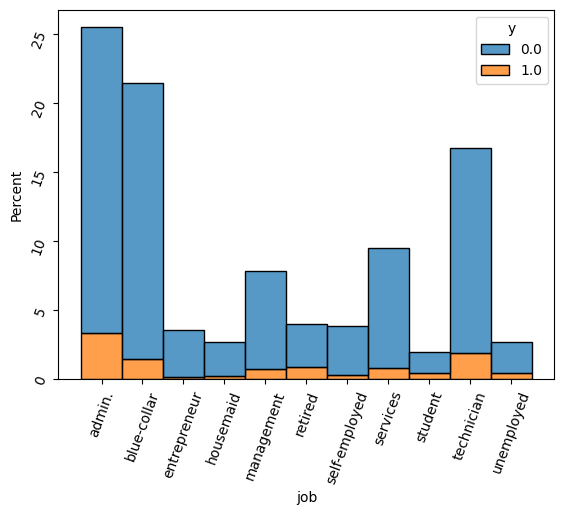

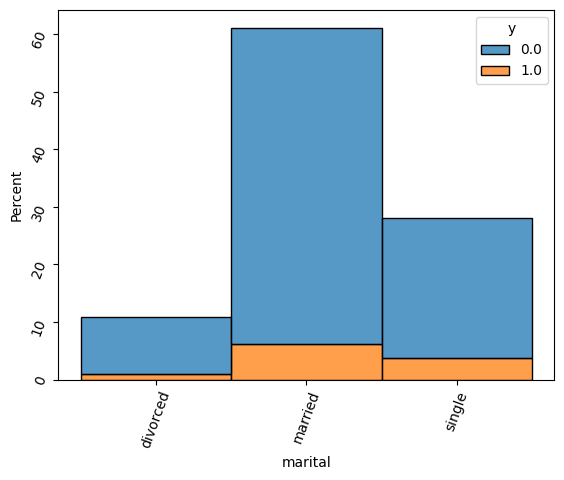

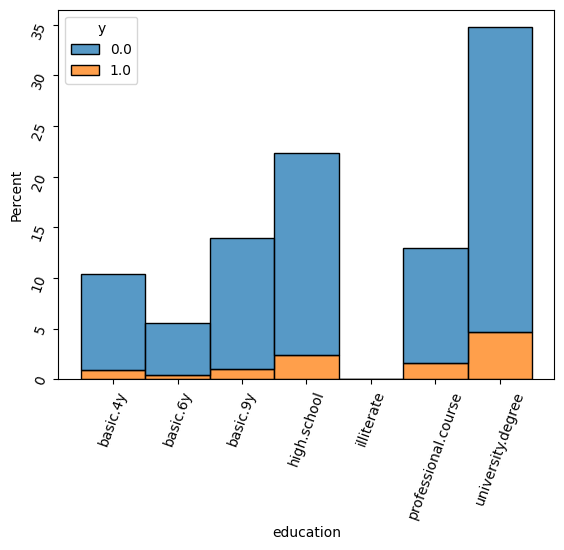

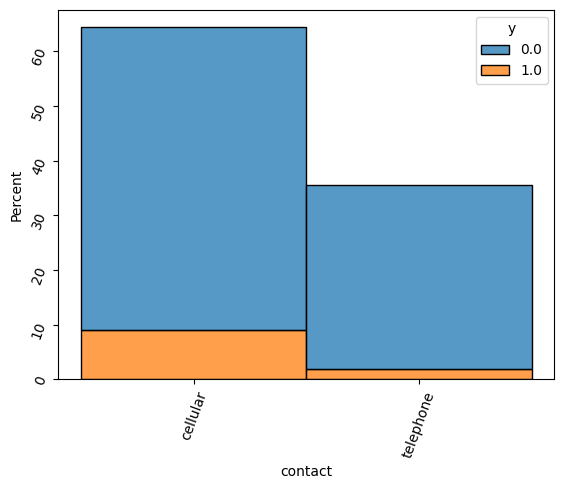

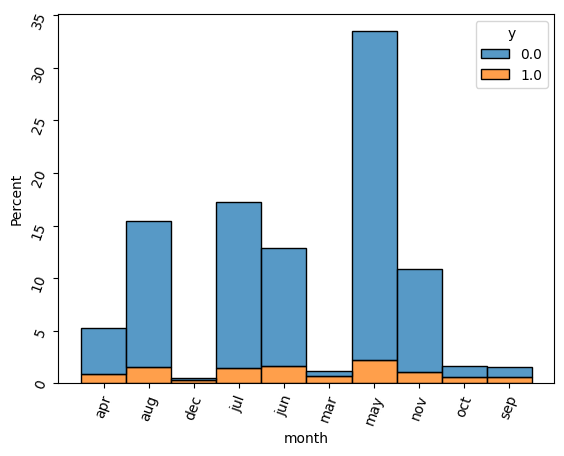

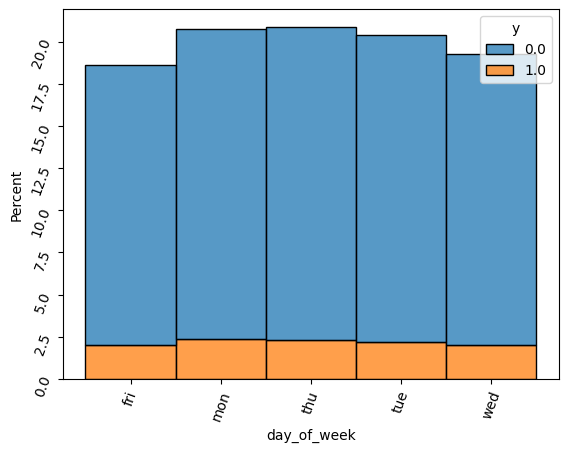

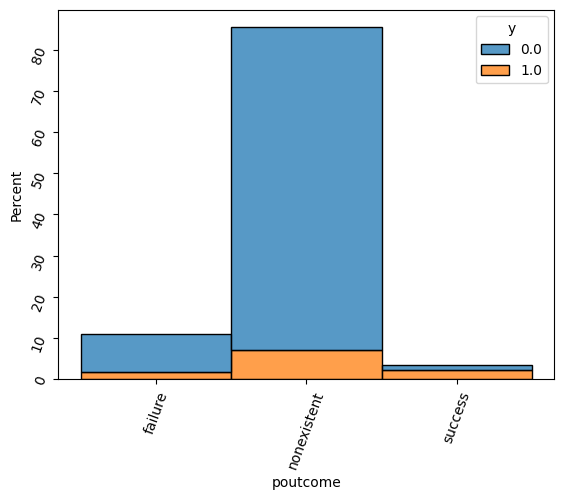

In [ ]:
for col in df.select_dtypes(['category']).columns:
  sns.histplot(data=df,x=col, stat='percent', discrete=True,
               hue='y', multiple='stack').tick_params(labelrotation=70);

  plt.show();

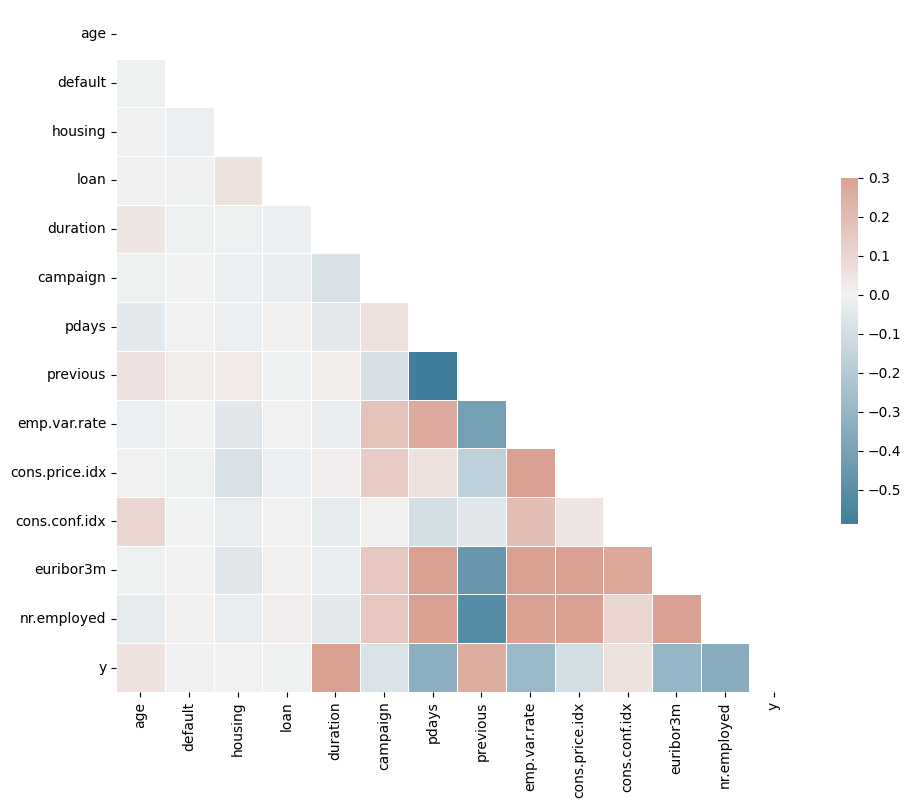

In [ ]:
# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Covariate Analysis

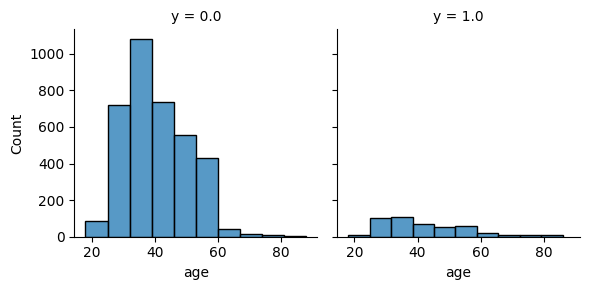

In [ ]:
# Influence of Age on buying the product
g = sns.FacetGrid(data=df, col='y')
g.map(sns.histplot,'age', bins=10);

(0.0, 0.0) 3.0
(1.0, 0.0) 1.0
(2.0, 0.0) 0.0
(3.0, 0.0) 0.0
(4.0, 0.0) 1.0
(5.0, 0.0) 1.0
(6.0, 0.0) 0.0
(7.0, 0.0) 1.0
(8.0, 0.0) 0.0
(9.0, 0.0) 2.0
(10.0, 0.0) 0.0
(-0.5, 0.0) 22.0
(0.5, 0.0) 20.0
(1.5, 0.0) 3.0
(2.5, 0.0) 2.0
(3.5, 0.0) 7.0
(4.5, 0.0) 3.0
(5.5, 0.0) 4.0
(6.5, 0.0) 9.0
(7.5, 0.0) 2.0
(8.5, 0.0) 15.0
(9.5, 0.0) 2.0


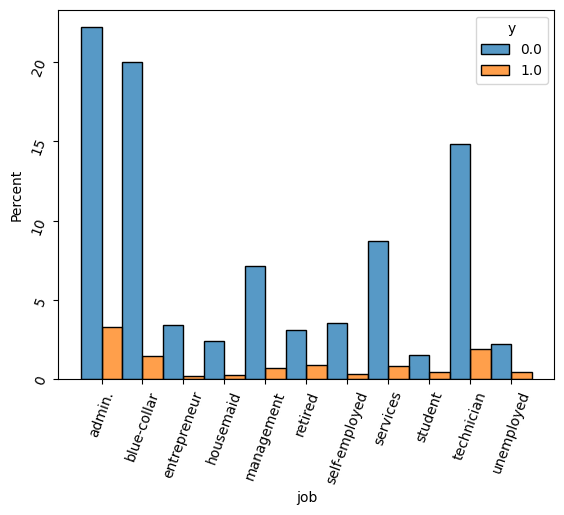

In [ ]:
# Influence of occupation on buying the product
ax=sns.histplot(data=df, x='job', hue='y',
                multiple='dodge', stat='percent',
                discrete=True)
ax.tick_params(labelrotation=70)
for label in ax.containers:
  # print(label[0].get_xy())
  for l in label:
    print(l.get_xy(),np.round(l.get_height()))
plt.show()

(-0.5, 0.0) 1.0
(0.5, 0.0) 6.0
(1.5, 0.0) 4.0
(-0.5, 1.0439427045399368) 10.0
(0.5, 6.14226754066521) 55.0
(1.5, 3.763049283806749) 24.0


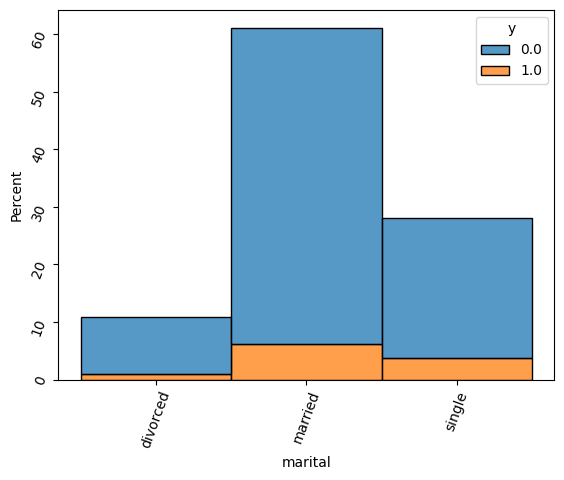

In [ ]:
# Influence of marital status on buying the product
ax=sns.histplot(data=df, x='marital', hue='y',
                multiple='stack', stat='percent',
                discrete=True)
ax.tick_params(labelrotation=70)
for label in ax.containers:
  for l in label:
    print(l.get_xy(),np.round(l.get_height()))
plt.show();

(-0.5, 0.0) 1.0
(0.5, 0.0) 0.0
(1.5, 0.0) 1.0
(2.5, 0.0) 2.0
(3.5, 0.0) 0.0
(4.5, 0.0) 2.0
(5.5, 0.0) 5.0
(-0.5, 0.9225540179655256) 9.0
(0.5, 0.4127215343529983) 5.0
(1.5, 1.0439427045399368) 13.0
(2.5, 2.3549405195435784) 20.0
(3.5, 0.0) 0.0
(4.5, 1.5780529254673465) 11.0
(5.5, 4.63704782714251) 30.0


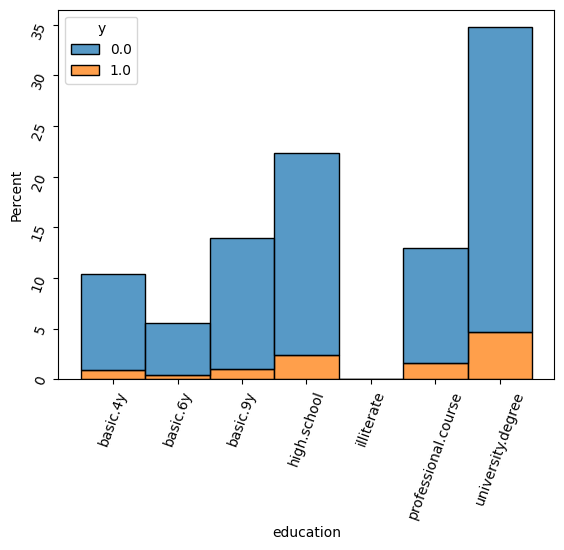

In [ ]:
# Influence of education status on buying the product
ax=sns.histplot(data=df, x='education', hue='y',
                multiple='stack', stat='percent',
                discrete=True)
ax.tick_params(labelrotation=70)
for label in ax.containers:
  for l in label:
    print(l.get_xy(),np.round(l.get_height()))
plt.show();

(-0.5, 0.0) 9.0
(0.5, 0.0) 2.0
(-0.5, 9.104151493080845) 55.0
(0.5, 1.8451080359310512) 34.0


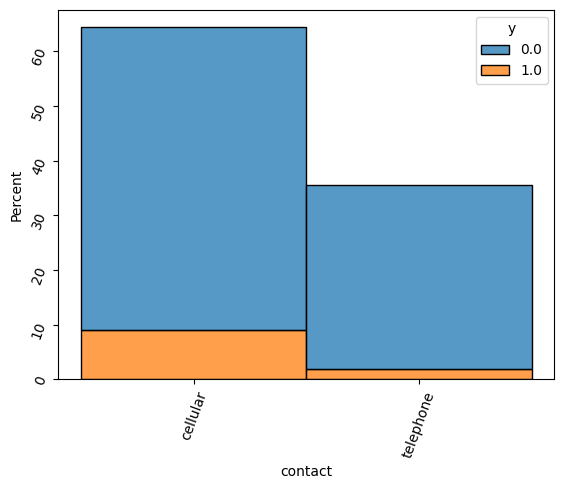

In [ ]:
# Influence of mode of contact on buying the product
ax=sns.histplot(data=df, x='contact', hue='y',
                multiple='stack', stat='percent',
                discrete=True)
ax.tick_params(labelrotation=70)
for label in ax.containers:
  for l in label:
    print(l.get_xy(),np.round(l.get_height()))
plt.show();

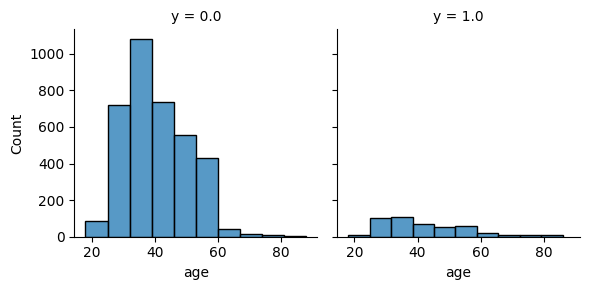

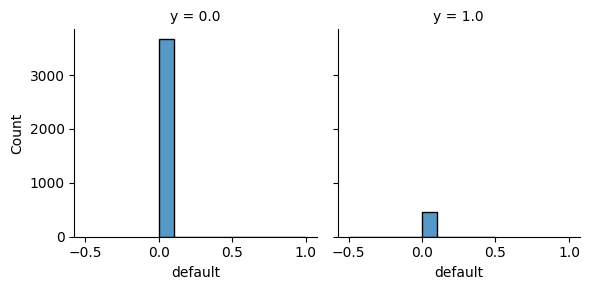

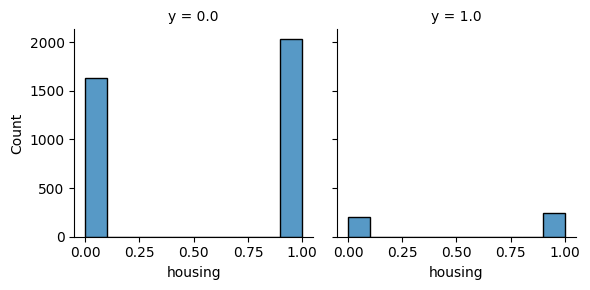

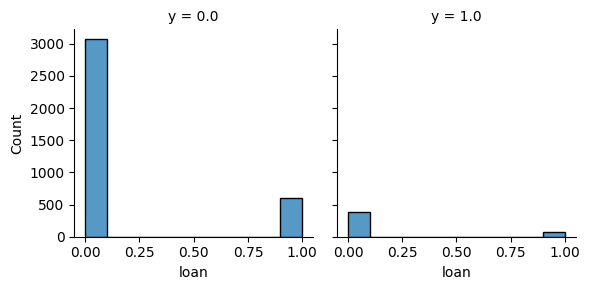

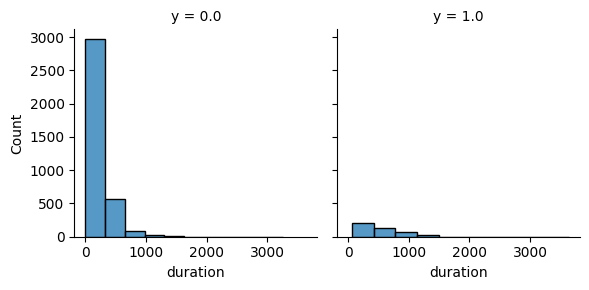

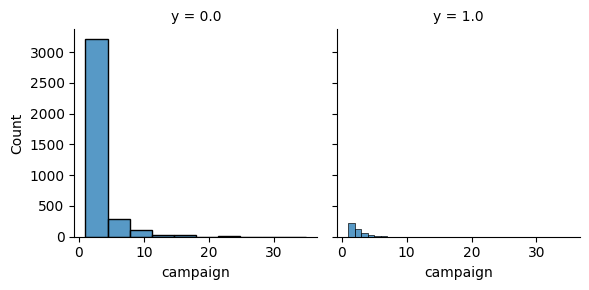

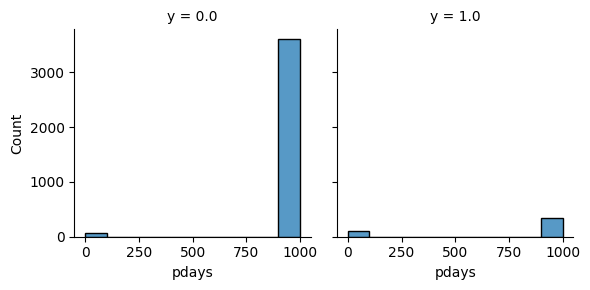

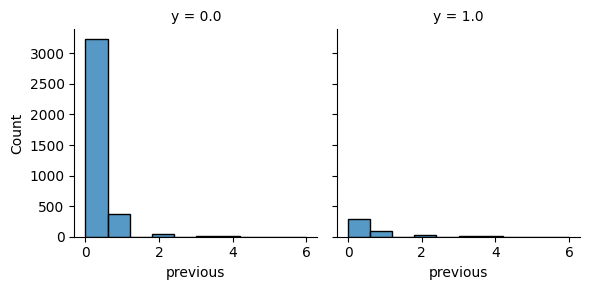

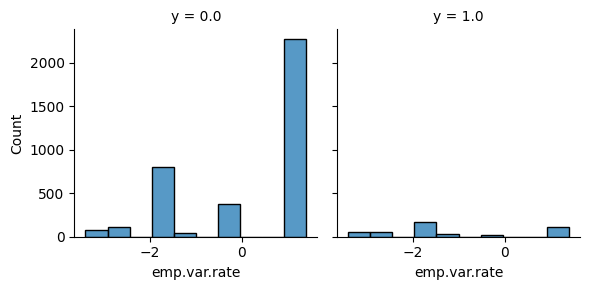

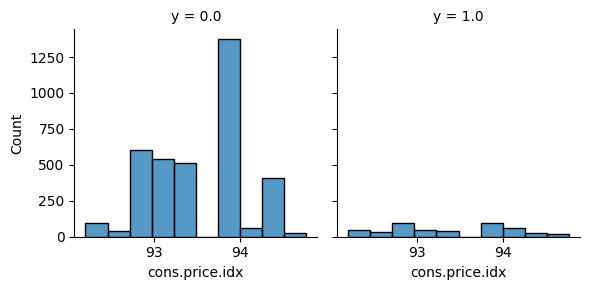

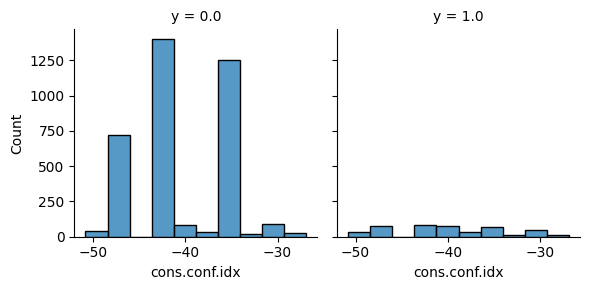

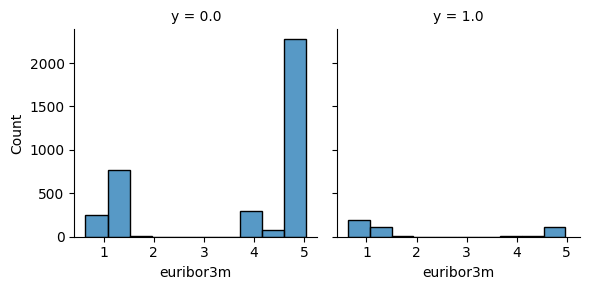

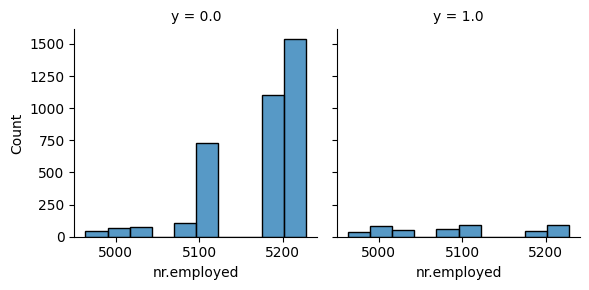

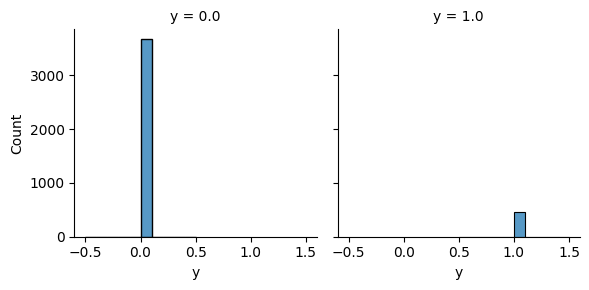

In [ ]:
# Influence of numerical cols on buying the product
for col in df.select_dtypes('float64').columns:
  g = sns.FacetGrid(data=df, col='y')
  g.map(sns.histplot,col, bins=10)
  plt.show();

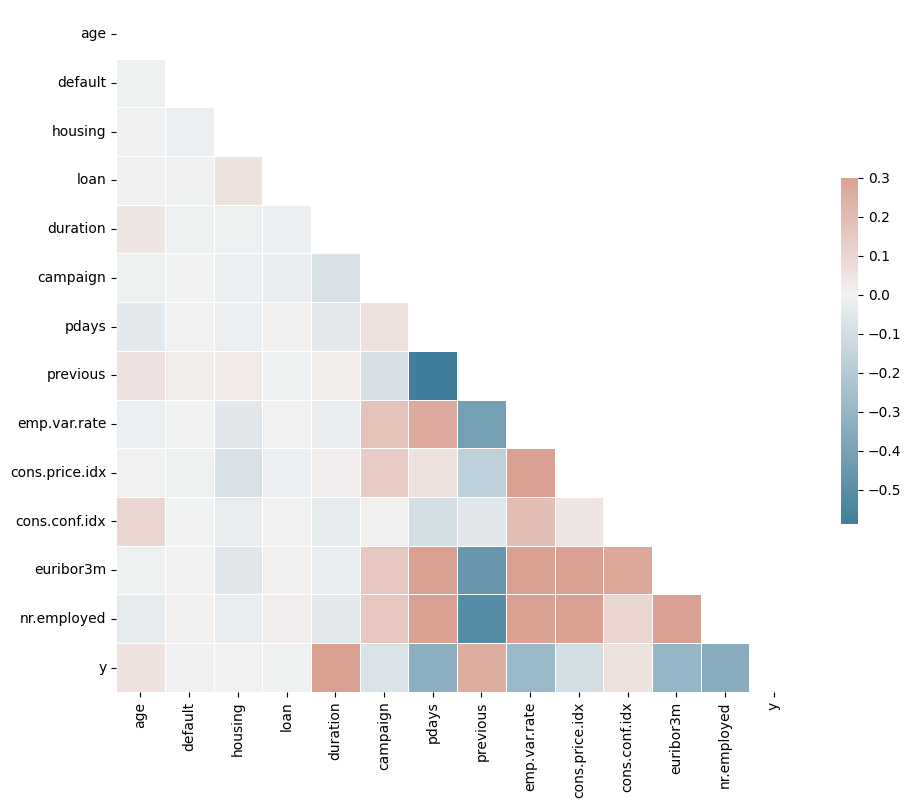

In [ ]:
# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

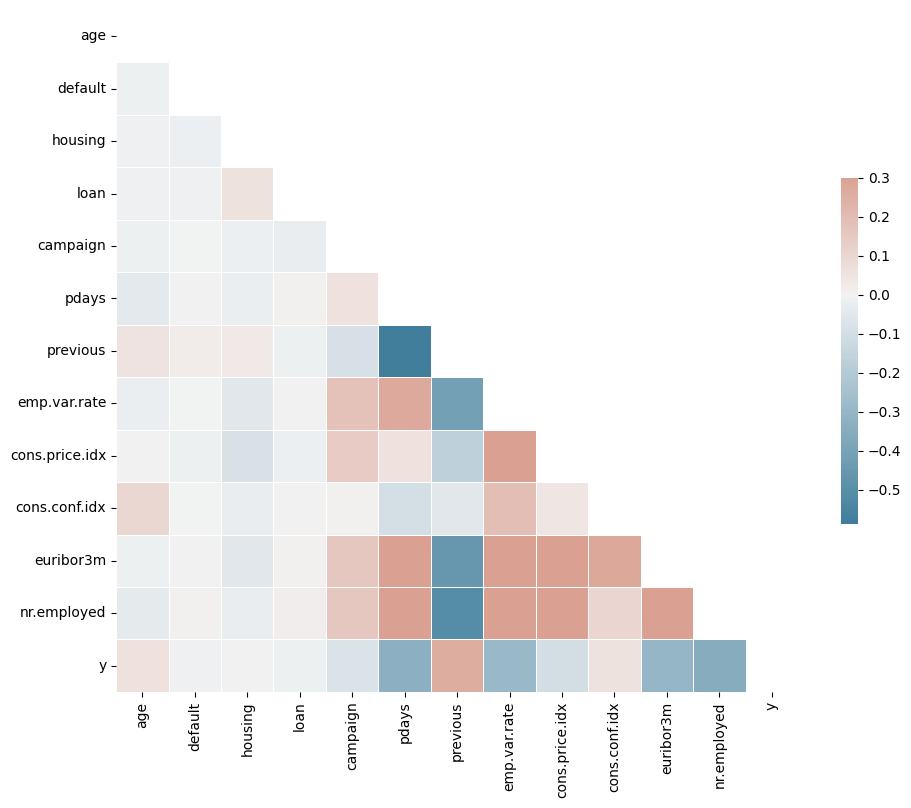

In [ ]:
# Compute the correlation matrix
corr = df.drop('duration',axis=1).corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Recommendation

1. Ages - 30 to 40 have a higher percentage of people who bought the product
2. 25% of Retired people bought the product and the product should be marked to them more.
3. 14% of Single people bought the product compared to 10% of married people and 9% of Divorced people.
4. People with professional course education - 15% bought the product and University degree education - 14% bought the product.
5. The correlation between numerical features and target shows that duration of last contact, previous number of contacts performed before this campaign and for this client have positive correlation towards the target. Now, the negative correlation was found to be the number of days that passed by after the client was last contacted from a previous campaign and the number of employees in the bank.


# Model recommendations

In [ ]:
df=cleanAndTransform(df_bank_additional)
df=pd.concat([df.select_dtypes(include='float64'),
         pd.get_dummies(df.select_dtypes(include='category'),
                        drop_first=True, dtype='float64')],
         axis=1)
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1),
                                                    df['y'], test_size=0.33,
                                                    stratify=df['y'])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2759, 47), (2759,), (1360, 47), (1360,))

In [ ]:
models_api=[DecisionTreeClassifier(),
            RandomForestClassifier(),
            SVC(),
            LogisticRegression(),
            SGDClassifier()]
# models_api=[RandomForestClassifier()]
model_names=['Decision Tree','Random Forest', 'Support Vector Machine',
             'Logistic Regression', 'Stochastic Gradient Descent']
models={}
model_,acc_score,prec_score,rec_score=[],[],[],[]
for i,clf in enumerate(models_api):
  # mclf=RandomForestClassifier()
  clf.fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  acc=accuracy_score(y_test,y_pred)
  prec=precision_score(y_test,y_pred)
  rec=recall_score(y_test,y_pred)
  model_.append(model_names[i])
  acc_score.append(acc)
  prec_score.append(prec)
  rec_score.append(rec)

models['model_name']=model_
models['accuracy']=acc_score
models['precision']=prec_score
models['recall']=rec_score

df_models = pd.DataFrame(models)


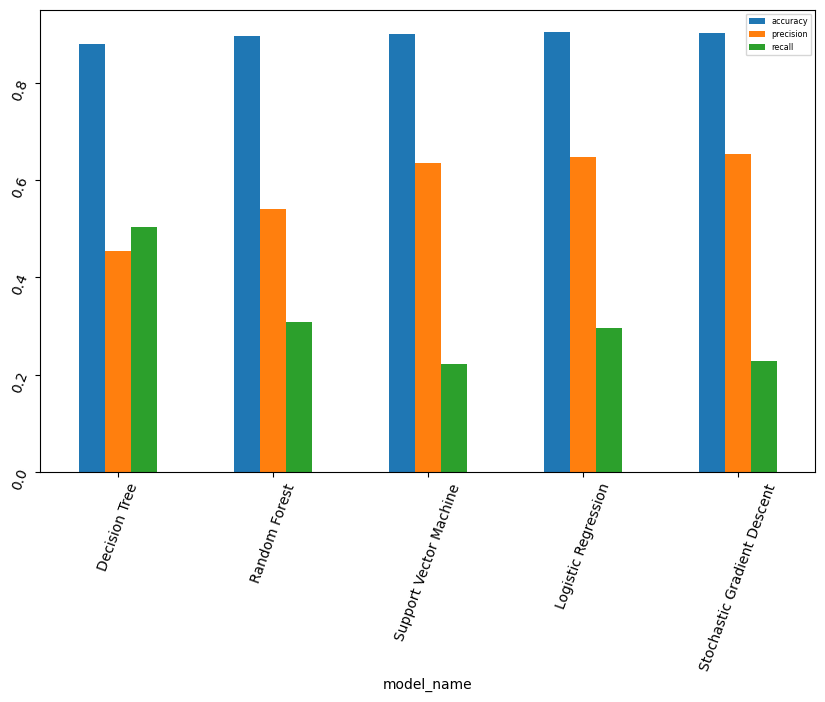

In [ ]:
df_models.set_index('model_name').plot(kind='bar', figsize=(10, 6))
plt.legend(fontsize='xx-small')
plt.tick_params(labelrotation=70);
plt.show();